In [1]:
import numpy as np 
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# 1/ Training data :

column_names = ['Model_name', 'input_shape', 'ACET', 'input_width', 'input_size', 'model_size', 'nb_params_no_fc', 
                'nb_params_fc', 'flops', 'nb_layers', 'nb_conv_layers', 'nb_fc_layers', 
                'sum_activations', 'weighted_sum_neurones']
raw_dataset = pd.read_csv('./training_dataset.csv', names=column_names,
                      na_values = "?", comment='\t', sep=",", skipinitialspace=True)
train_dataset = raw_dataset.copy()
train_dataset.isna().sum()
train_dataset = train_dataset.dropna()
train_dataset.tail()

,Model_name,input_shape,ACET,input_width,input_size,model_size,nb_params_no_fc,nb_params_fc,flops,nb_layers,nb_conv_layers,nb_fc_layers,sum_activations,weighted_sum_neurones
1521,DPN-137,"(1, 480, 480, 3)",236.347517,480,691200,319.7,76725504,2688000,147429883398,4072,1811,1,761714152,74962944000
1522,DPN-137,"(1, 568, 568, 3)",306.702618,568,967872,319.7,76725504,2688000,210363824006,4072,1811,1,1079996072,107007131648
1523,DPN-137,"(1, 600, 600, 3)",331.850612,600,1080000,319.7,76725504,2688000,234455319558,4072,1811,1,1204310184,119281811456
1524,DPN-137,"(1, 800, 800, 3)",520.859203,800,1920000,319.7,76725504,2688000,408964654598,4072,1811,1,2115851752,208230400000
1525,DPN-137,"(1, 896, 896, 3)",650.251626,896,2408448,319.7,76725504,2688000,512924726150,4072,1811,1,2654121448,261204213760


In [49]:
# 1/ Test data :

column_names = ['Model_name', 'input_shape', 'ACET', 'input_width', 'input_size', 'model_size', 'nb_params_no_fc', 
                'nb_params_fc', 'flops', 'nb_layers', 'nb_conv_layers', 'nb_fc_layers', 
                'sum_activations', 'weighted_sum_neurones']
raw_dataset = pd.read_csv('./test_dim3.csv', names=column_names,
                      na_values = "?", comment='\t', sep=",", skipinitialspace=True)
test_dataset = raw_dataset.copy()
test_dataset.isna().sum()
test_dataset = test_dataset.dropna()
test_dataset.tail()

,Model_name,input_shape,ACET,input_width,input_size,model_size,nb_params_no_fc,nb_params_fc,flops,nb_layers,nb_conv_layers,nb_fc_layers,sum_activations,weighted_sum_neurones
19,NASNet-Mobile,"(1, 331, 331, 3)",16.397280,331,328683,22.2,4269716,1057000,2629916665,771,196,1,62189815,9731133896
20,NASNet-Large,"(1, 64, 64, 3)",49.317171,64,12288,357.0,84916818,4033000,1868148675,1041,268,1,10813366,6709743072
21,NASNet-Large,"(1, 128, 128, 3)",53.963382,128,49152,357.0,84916818,4033000,6917229891,1041,268,1,42382774,26839800288
22,NASNet-Large,"(1, 256, 256, 3)",80.010125,256,196608,357.0,84916818,4033000,27115250499,1041,268,1,168061366,107360877024
23,NASNet-Large,"(1, 331, 331, 3)",110.658881,331,328683,357.0,84916818,4033000,47876527473,1041,268,1,290560171,191031310656


In [4]:
train_dataset.pop('input_width')
train_dataset.pop('model_size')

0         1.9
1         1.9
2         1.9
3         1.9
4         1.9
        ...  
1521    319.7
1522    319.7
1523    319.7
1524    319.7
1525    319.7
Name: model_size, Length: 1526, dtype: float64

In [50]:
test_dataset.pop('input_width')
test_dataset.pop('model_size')

0       5.0
1       5.0
2       5.0
3       5.0
4       5.0
5       5.0
6       5.0
7       5.0
8       5.0
9       5.0
10      5.0
11    276.6
12    679.3
13    197.2
14    297.9
15    700.5
16     22.2
17     22.2
18     22.2
19     22.2
20    357.0
21    357.0
22    357.0
23    357.0
Name: model_size, dtype: float64

In [6]:
Y = train_dataset.pop('ACET')
X = train_dataset

In [7]:
#test_dataset.tail()
#X.tail()
#Y.tail()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=42, shuffle=True)

In [9]:
X_train_model_names = X_train.pop('Model_name')
X_train_input_shapes = X_train.pop('input_shape')
X_test_model_names = X_test.pop('Model_name')
X_test_input_shapes = X_test.pop('input_shape')

In [10]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [51]:
Y_e = test_dataset.pop('ACET')
X_e = test_dataset
X_e.tail()

,Model_name,input_shape,input_size,nb_params_no_fc,nb_params_fc,flops,nb_layers,nb_conv_layers,nb_fc_layers,sum_activations,weighted_sum_neurones
19,NASNet-Mobile,"(1, 331, 331, 3)",328683,4269716,1057000,2629916665,771,196,1,62189815,9731133896
20,NASNet-Large,"(1, 64, 64, 3)",12288,84916818,4033000,1868148675,1041,268,1,10813366,6709743072
21,NASNet-Large,"(1, 128, 128, 3)",49152,84916818,4033000,6917229891,1041,268,1,42382774,26839800288
22,NASNet-Large,"(1, 256, 256, 3)",196608,84916818,4033000,27115250499,1041,268,1,168061366,107360877024
23,NASNet-Large,"(1, 331, 331, 3)",328683,84916818,4033000,47876527473,1041,268,1,290560171,191031310656


In [52]:
X_test_e_model_names = X_e.pop('Model_name')
X_test_e_input_shapes = X_e.pop('input_shape')

In [53]:
dtest_e = xgb.DMatrix(X_e, label=Y_e)

In [14]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
}

In [15]:
params['eval_metric'] = "mae"
num_boost_round = 1000

In [16]:
print(params)

{'max_depth': 6, 'min_child_weight': 1, 'eta': 0.3, 'subsample': 1, 'colsample_bytree': 1, 'objective': 'reg:squarederror', 'eval_metric': 'mae'}


In [0]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=10,
    metrics={'mae'},
    early_stopping_rounds=10
)

In [0]:
print(cv_results)
cv_results['test-mae-mean'].min()

     train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
0         79.035869       3.571896      81.129722     37.157488
1         57.778421       2.639794      60.861173     31.074918
2         42.573491       1.900720      45.776081     26.130036
3         31.646147       1.359266      34.930937     21.475082
4         23.860037       0.994206      28.042261     17.745699
..              ...            ...            ...           ...
324        0.016892       0.002164      14.422153     11.814874
325        0.016651       0.002139      14.422093     11.814845
326        0.016459       0.002072      14.422123     11.814807
327        0.016279       0.002054      14.422126     11.814725
328        0.016066       0.002003      14.422090     11.814762

[329 rows x 4 columns]


14.4220901

In [0]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(6,20)
    for min_child_weight in range(5,20)
]

In [0]:
# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))    
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight    
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=10,
        metrics={'mae'},
        early_stopping_rounds=10
    )    
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)

print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=6, min_child_weight=5
	MAE 20.3945562 for 11 rounds
CV with max_depth=6, min_child_weight=6
	MAE 22.208952399999998 for 13 rounds
CV with max_depth=6, min_child_weight=7
	MAE 22.229876600000004 for 12 rounds
CV with max_depth=6, min_child_weight=8
	MAE 21.297145899999997 for 12 rounds
CV with max_depth=6, min_child_weight=9
	MAE 23.6543731 for 10 rounds
CV with max_depth=6, min_child_weight=10
	MAE 24.488140100000003 for 8 rounds
CV with max_depth=6, min_child_weight=11
	MAE 24.6284266 for 10 rounds
CV with max_depth=6, min_child_weight=12
	MAE 24.8543376 for 8 rounds
CV with max_depth=6, min_child_weight=13
	MAE 23.4193608 for 49 rounds
CV with max_depth=6, min_child_weight=14
	MAE 25.957476200000002 for 18 rounds
CV with max_depth=6, min_child_weight=15
	MAE 25.7721503 for 9 rounds
CV with max_depth=6, min_child_weight=16
	MAE 27.9733274 for 9 rounds
CV with max_depth=6, min_child_weight=17
	MAE 29.223658699999998 for 7 rounds
CV with max_depth=6, min_child_weight=1

In [17]:
# tune with the best params
params['max_depth'] = 14
params['min_child_weight'] = 5

In [0]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [0]:
min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))    
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample    
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=10,
        metrics={'mae'},
        early_stopping_rounds=10
    )    
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)

print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with subsample=1.0, colsample=1.0
	MAE 18.8100393 for 11 rounds
CV with subsample=1.0, colsample=0.9
	MAE 17.5339356 for 11 rounds
CV with subsample=1.0, colsample=0.8
	MAE 19.1267883 for 22 rounds
CV with subsample=1.0, colsample=0.7
	MAE 20.1066362 for 31 rounds
CV with subsample=0.9, colsample=1.0
	MAE 19.360101200000003 for 14 rounds
CV with subsample=0.9, colsample=0.9
	MAE 18.684887300000003 for 14 rounds
CV with subsample=0.9, colsample=0.8
	MAE 18.9389568 for 13 rounds
CV with subsample=0.9, colsample=0.7
	MAE 19.3570067 for 13 rounds
CV with subsample=0.8, colsample=1.0
	MAE 18.495414800000002 for 14 rounds
CV with subsample=0.8, colsample=0.9
	MAE 18.3095238 for 17 rounds
CV with subsample=0.8, colsample=0.8
	MAE 18.365425499999997 for 19 rounds
CV with subsample=0.8, colsample=0.7
	MAE 21.245757 for 14 rounds
CV with subsample=0.7, colsample=1.0
	MAE 19.4181991 for 22 rounds
CV with subsample=0.7, colsample=0.9
	MAE 20.901118599999997 for 22 rounds
CV with subsample=0.7, 

In [18]:
#Update the params dictionnary
params['subsample'] = 1.
params['colsample_bytree'] = .9

In [0]:
# This can take some time…
min_mae = float("Inf")
best_params = None

for eta in [.3, .2, .1, .05, .01, .005, .001, .0005, .0001]:
    print("CV with eta={}".format(eta))    
    # We update our parameters
    params['eta'] = eta    
    # Run and time CV
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=10,
            metrics=['mae'],
            early_stopping_rounds=10
          )    
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("Best params: {}, MAE: {}".format(best_params, min_mae))        

CV with eta=0.3
	MAE 17.5339356 for 11 rounds

CV with eta=0.2
	MAE 16.6204344 for 22 rounds

CV with eta=0.1
	MAE 16.8260567 for 50 rounds

CV with eta=0.05
	MAE 17.2577423 for 88 rounds

CV with eta=0.01
	MAE 17.2756413 for 445 rounds

CV with eta=0.005
	MAE 17.2726613 for 894 rounds

CV with eta=0.001
	MAE 43.5209716 for 999 rounds

CV with eta=0.0005
	MAE 68.7765484 for 999 rounds

CV with eta=0.0001
	MAE 99.60887799999999 for 999 rounds

Best params: 0.2, MAE: 16.6204344


In [19]:
# Update the param ETA
params['eta'] = .2

In [20]:
print(params)

{'max_depth': 14, 'min_child_weight': 5, 'eta': 0.2, 'subsample': 1.0, 'colsample_bytree': 0.9, 'objective': 'reg:squarederror', 'eval_metric': 'mae'}


In [21]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-mae:99.13345
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:81.45215
[2]	Test-mae:66.33253
[3]	Test-mae:54.13283
[4]	Test-mae:44.79357
[5]	Test-mae:37.05714
[6]	Test-mae:31.29118
[7]	Test-mae:26.55886
[8]	Test-mae:23.04575
[9]	Test-mae:20.16986
[10]	Test-mae:18.14636
[11]	Test-mae:16.47836
[12]	Test-mae:15.34056
[13]	Test-mae:14.39410
[14]	Test-mae:13.64360
[15]	Test-mae:13.43517
[16]	Test-mae:13.39934
[17]	Test-mae:15.06658
[18]	Test-mae:15.04937
[19]	Test-mae:14.99745
[20]	Test-mae:14.75670
[21]	Test-mae:14.66359
[22]	Test-mae:14.64570
[23]	Test-mae:14.45752
[24]	Test-mae:14.53180
[25]	Test-mae:14.50569
[26]	Test-mae:14.50316
Stopping. Best iteration:
[16]	Test-mae:13.39934



In [22]:
print("Best MAE: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

Best MAE: 13.40 in 17 rounds


In [23]:
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[0]	Test-mae:99.13345
[1]	Test-mae:81.45215
[2]	Test-mae:66.33253
[3]	Test-mae:54.13283
[4]	Test-mae:44.79357
[5]	Test-mae:37.05714
[6]	Test-mae:31.29118
[7]	Test-mae:26.55886
[8]	Test-mae:23.04575
[9]	Test-mae:20.16986
[10]	Test-mae:18.14636
[11]	Test-mae:16.47836
[12]	Test-mae:15.34056
[13]	Test-mae:14.39410
[14]	Test-mae:13.64360
[15]	Test-mae:13.43517
[16]	Test-mae:13.39933


In [24]:
best_model = model
mean_absolute_error(best_model.predict(dtest), y_test)

14.503160912137997

In [25]:
#best_model.save_model("model_16-04.model")

In [26]:
#loaded_model = xgb.Booster()
#loaded_model.load_model("model_16-04.model")

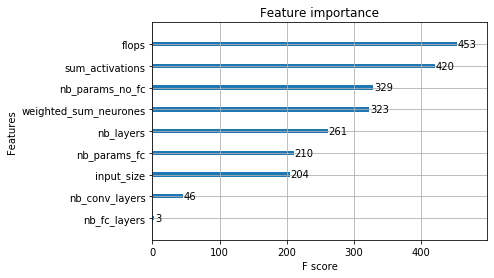

In [27]:
loaded_model = best_model
xgb.plot_importance(loaded_model)

In [54]:
# Make predictions on our test dataset.
y_pred = loaded_model.predict(dtest_e)
np_test = Y_e.values
y_test = Y_e.values

In [56]:
# Model evaluation on test dataset
print('Explained variance : ',explained_variance_score(y_test, y_pred))
print('R2_value : ',r2_score(y_test, y_pred))
print('Mean absolute error :', mean_absolute_error(y_test, y_pred))
print('Median absolute error :', median_absolute_error(y_test, y_pred))

Explained variance :  0.9327738090136074
R2_value :  0.9298185998354692
Mean absolute error : 2.8897788459771045
Median absolute error : 0.5974370552679478


In [58]:
# Calculate mean absolute percentage error (MAPE)
np_test = y_test
errors = abs(y_pred-np_test)
mape = 100 * (errors / np_test) # Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 87.44 %.


In [59]:
test_models = X_test_e_model_names.values
test_input_shapes = X_test_e_input_shapes.values
for i in range(0, len(y_pred)) :
    print(test_models[i], test_input_shapes[i], y_pred[i], np_test[i], 100-((abs(y_pred[i]-np_test[i]))/np_test[i])*100)

SqueezeNet-v1.1 (1, 90, 90, 3) 0.984137 0.98912147 99.49607085704164
SqueezeNet-v1.1 (1, 512, 512, 3) 5.630608 5.2278544 92.2960042303851
SqueezeNet-v1.1 (1, 720, 720, 3) 11.6773815 9.7607754 80.36420225894216
SqueezeNet-v1.1 (64, 64, 3) 0.8991362 0.9090424587155959 98.91025188377499
SqueezeNet-v1.1 (128, 128, 3) 1.5385134 1.15266463302752 66.52549423926007
SqueezeNet-v1.1 (224, 224, 3) 1.9174504 1.85750548623853 96.77282558707849
SqueezeNet-v1.1 (240, 240, 3) 1.9600127 1.91482706422018 97.64022501270175
SqueezeNet-v1.1 (256, 256, 3) 1.9622834 1.9958535321100899 98.31800486904618
SqueezeNet-v1.1 (299, 299, 3) 2.2685566 2.75664246788991 82.29419017059234
SqueezeNet-v1.1 (448, 448, 3) 5.5974593 4.373639853211009 72.01828444689707
SqueezeNet-v1.1 (1024, 1024, 3) 25.201513 17.705117018348602 57.65971914058618
VGG-16 (1, 128, 128, 3) 19.282198 15.53275248 75.86103636751888
VGG-16 (1, 256, 256, 3) 22.171097 31.85314821 69.60409895935311
VGG-19 (1, 64, 64, 3) 15.702145 15.64801341 99.65406974

In [60]:
import csv
with open('./evaluation_results/measured_vs_predicted_XGBoost_dim3.csv', 'a', newline='') as file : 
    writer = csv.writer(file)
    for i in range(0, len(y_pred)) :
        writer.writerow([test_models[i], test_input_shapes[i], np_test[i], y_pred[i],abs(y_pred[i]-np_test[i]), 100-((abs(y_pred[i]-np_test[i]))/np_test[i])*100])

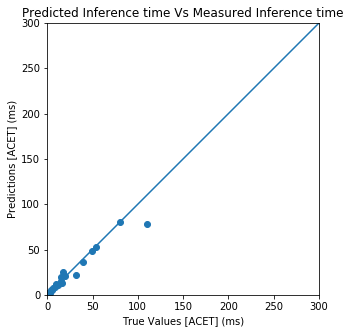

In [61]:
plt.figure(figsize=(10,5))
a = plt.axes(aspect='equal')
plt.scatter(np_test, y_pred)
plt.title('Predicted Inference time Vs Measured Inference time')
plt.xlabel('True Values [ACET] (ms)')
plt.ylabel('Predictions [ACET] (ms)')
lims = [0, 300]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.savefig('./evaluation_results/measured_vs_predicted_XGBoost_dim3.png', dpi=600)

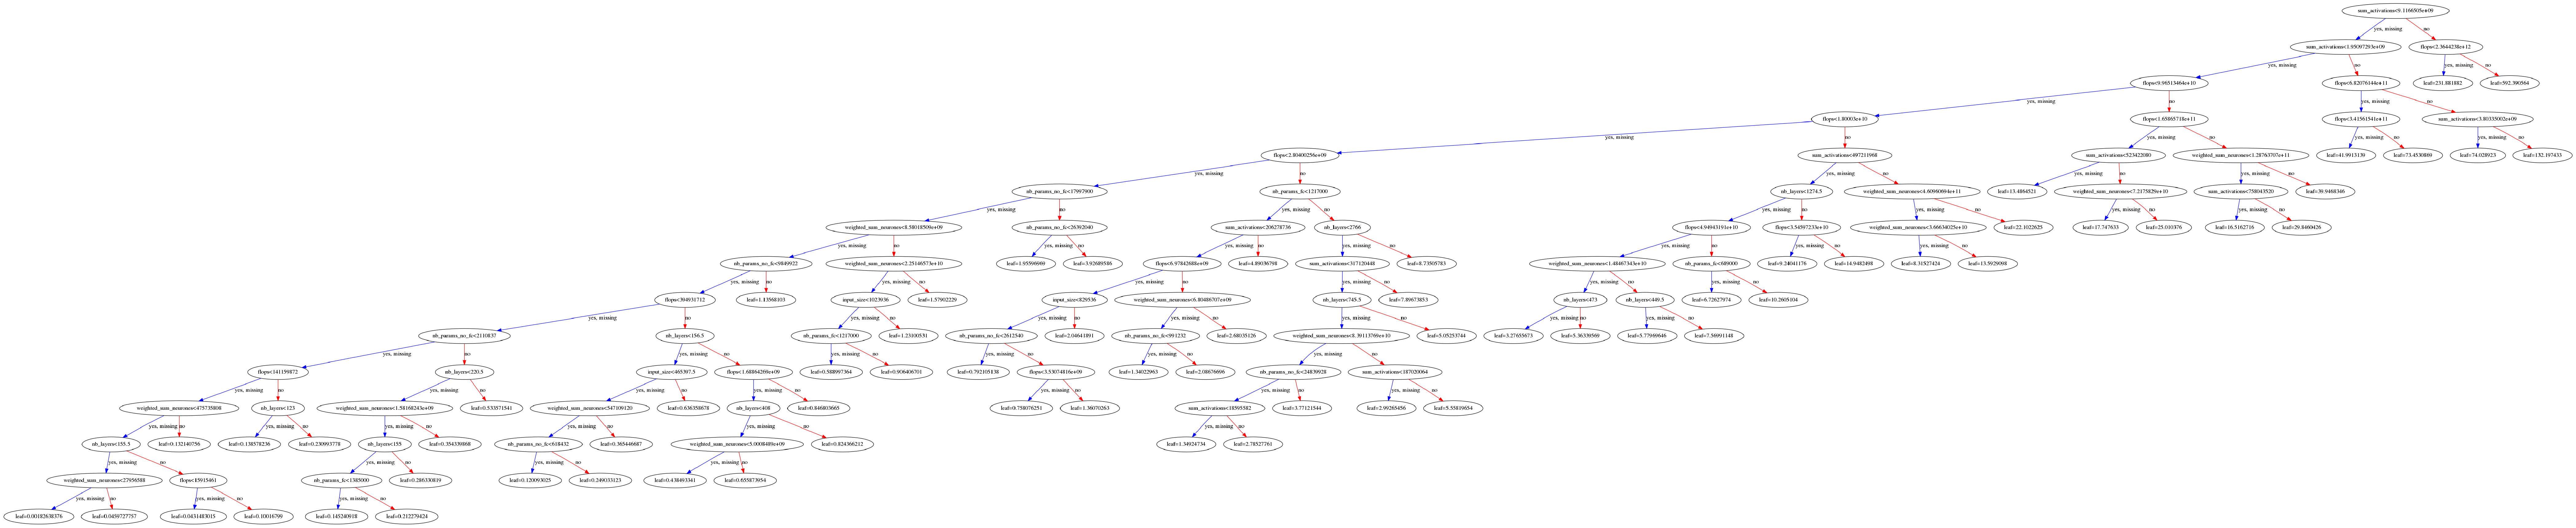

In [62]:
from xgboost import plot_tree
fig, ax = plt.subplots(figsize=(150, 150))
xgb.plot_tree(model, num_trees=2, ax=ax)
plt.savefig("xgboost_tree.png")